Means: [0.08140734 0.81386419]
Variances: [0.00246154 0.00750741]
Mixing Weights: [0.58431274 0.41568726]


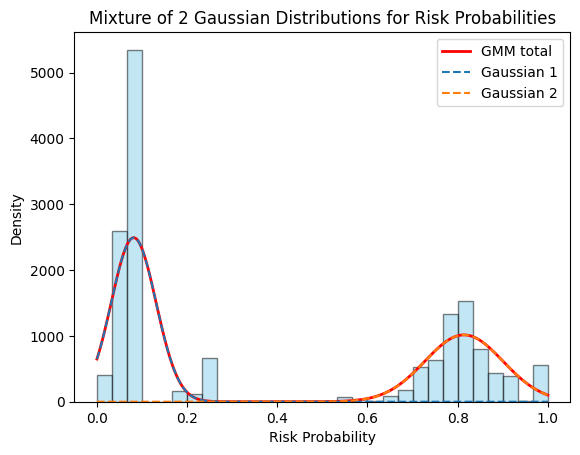

In [3]:
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import contextily as ctx

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

# 1) Read GeoJSON file
gdf_result = gpd.read_file("similarity_matrix_result.geojson")

# 2) Extract the risk probability values (adjust the column name as needed)
data = gdf_result["risk_probability"].dropna().values

# 3) Reshape data as a 2D array for scikit-learn
X = data.reshape(-1, 1)

# 4) Fit a 2-component Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# 5) Retrieve fitted parameters
means = gmm.means_.flatten()         # Means of the two Gaussians
covars = gmm.covariances_.flatten()  # Variances of the two Gaussians
weights = gmm.weights_               # Mixing weights

print("Means:", means)
print("Variances:", covars)
print("Mixing Weights:", weights)

# 6) Plot histogram in frequencies (NOT densities)
counts, bins, _ = plt.hist(data, bins=30, alpha=0.5, color='skyblue',
                           edgecolor='black')

# Calculate bin width for rescaling PDFs
bin_width = bins[1] - bins[0]
n_samples = len(data)  # total number of data points

# 7) Generate PDF values across 0..1
x = np.linspace(0, 1, 500).reshape(-1, 1)
log_probs = gmm.score_samples(x)
pdf_vals = np.exp(log_probs)  # this integrates to 1 over the domain

# -- Rescale PDF for plotting against raw counts --
pdf_counts = pdf_vals * n_samples * bin_width

# 8) Plot the total GMM curve on frequency scale
plt.plot(x, pdf_counts, 'r-', lw=2, label='GMM total')

# 9) Plot each Gaussian’s component (also scaled)
for i in range(2):
    mu = means[i]
    sigma = np.sqrt(covars[i])
    w = weights[i]
    component_pdf = w * norm.pdf(x, mu, sigma)
    component_counts = component_pdf * n_samples * bin_width
    plt.plot(x, component_counts, '--', lw=1.5, label=f'Gaussian {i+1}')

plt.title("Mixture of 2 Gaussian Distributions for Risk Probabilities")
plt.xlabel("Risk Probability")
plt.ylabel("Density")
plt.legend()
plt.show()